In [1]:
%matplotlib inline 
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf 

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.utils.vis_utils import plot_model



/Users/omar/mapping/maptimeSG/env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [3]:
img_width, img_height = 256, 256
batch_size = 16
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


In [4]:
# Let's try the keras example of train + mask images in a pair of directories

data_gen_args = dict(rescale=1./255,
                     #brightness_range=(0.6, 1.0),
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit('data/keras/train/images', augment=True, seed=seed)
#mask_datagen.fit('data/keras/mask/images', augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    '../data/keras/train',
    class_mode=None,
    seed=seed,
    color_mode='rgb')

mask_generator = mask_datagen.flow_from_directory(
    '../data/keras/mask',
    class_mode=None,
    seed=seed,
    color_mode='grayscale')

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 119255 images belonging to 1 classes.
Found 119255 images belonging to 1 classes.


(32, 256, 256, 3)
(256, 256, 1)


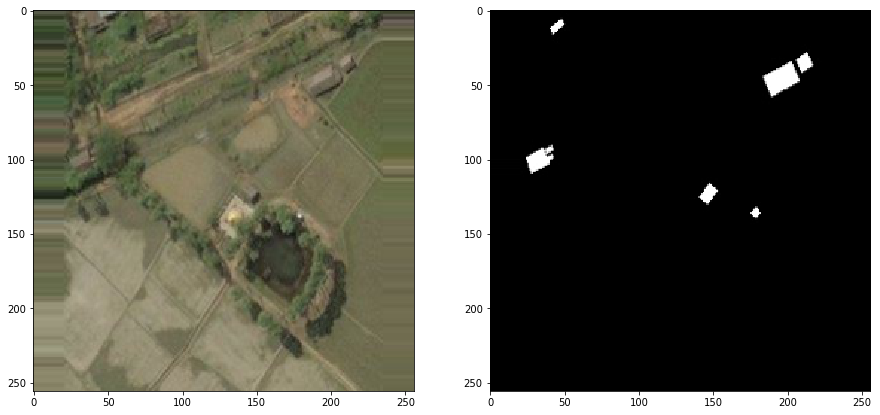

In [43]:
(img, mask) = next(train_generator)

plt.figure(figsize=(15, 30))

print(img.shape)
print(mask[0].shape)

plt.subplot(121).imshow(np.array(img[0], dtype='float'))
plt.subplot(122).imshow(np.array(mask[0], dtype='float').reshape(256, 256), cmap='gray')



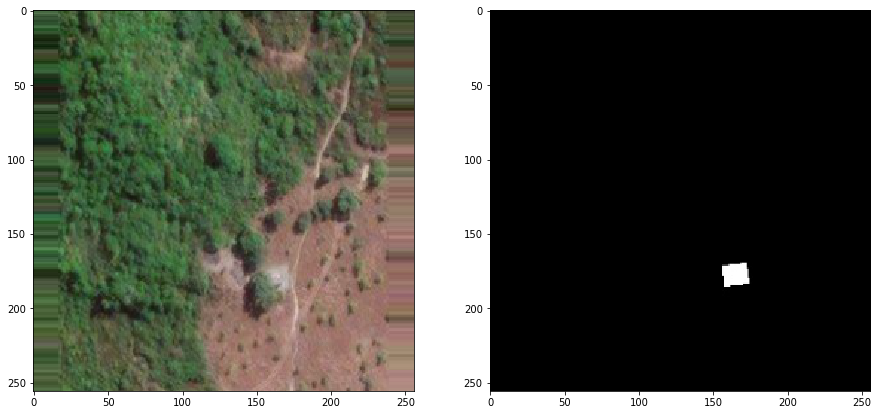

In [10]:
plt.figure(figsize=(15, 30))

i = 11
plt.subplot(121).imshow(np.array(img[i], dtype='float'))
plt.subplot(122).imshow(np.array(mask[i], dtype='float').reshape(256, 256), cmap='gray')


In [11]:
# Try to wire these up to *some* form of network



def build_model(input_layer, start_neurons):
    # 256 -> 128
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1) # Dropout skipped due to bug in tensorflow+python3.7

    # 128 -> 64
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    # 64 -> 32
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    # 32 -> 16
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    # 16 -> 32
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 32 -> 64
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 64 -> 128
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    #uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 128 -> 256
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


In [15]:
# Try to wire these up to *some* form of network



def build_limited_model(input_layer, start_neurons):
    # 256 -> 128
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1) # Dropout skipped due to bug in tensorflow+python3.7


    # Middle
    convm = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    convm = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(convm)
    

    # 128 -> 256
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


In [12]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = k.sum(k.abs(y_true * y_pred), axis=-1)
    sum_ = k.sum(k.abs(y_true) + k.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [108]:


img_size = 256

input_layer = Input((img_size, img_size, 3))

# Big giant model 
#output_layer = build_model(input_layer, 16)

# Limited model 
output_layer = build_limited_model(input_layer, 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
#model.compile(loss=jaccard_distance_loss, optimizer="adam", metrics=["accuracy"])

In [109]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 

In [110]:
early_stopping = EarlyStopping(patience=10, verbose=1, monitor="loss")
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1, monitor="loss")

epochs = 10
steps_per_epoch=250
batch_size = 32

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/10
249/250 [============================>.] - ETA: 15s - loss: 2.4092 - acc: 0.9783
Epoch 00001: saving model to ./keras.model
250/250 [==============================] - 3765s 15s/step - loss: 2.4051 - acc: 0.9783
Epoch 2/10
249/250 [============================>.] - ETA: 16s - loss: 1.5516 - acc: 0.9779
Epoch 00002: saving model to ./keras.model
250/250 [==============================] - 4027s 16s/step - loss: 1.5536 - acc: 0.9779
Epoch 3/10
249/250 [============================>.] - ETA: 14s - loss: 1.3686 - acc: 0.9789
Epoch 00003: saving model to ./keras.model
250/250 [==============================] - 3742s 15s/step - loss: 1.3677 - acc: 0.9789
Epoch 4/10
249/250 [============================>.] - ETA: 14s - loss: 1.3537 - acc: 0.9777
Epoch 00004: saving model to ./keras.model
250/250 [==============================] - 3747s 15s/step - loss: 1.3529 - acc: 0.9777
Epoch 5/10
249/250 [============================>.] - ETA: 14s - loss: 1.3186 - acc: 0.9779
Epoch 00005: saving 

In [111]:
model.save('model-small-cross-250-10-b.model')

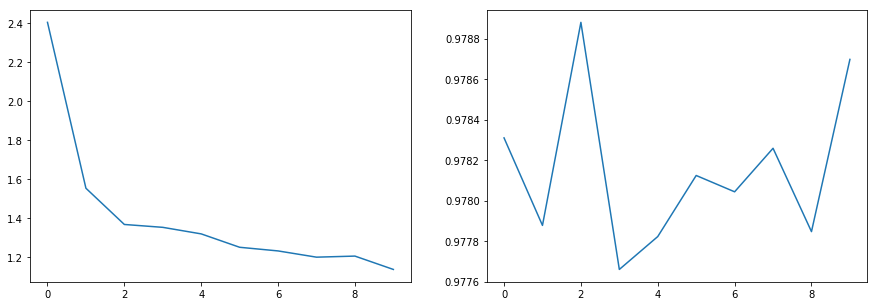

In [112]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
#ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
#ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [113]:
preds = model.predict(img)

In [114]:
sum(preds[4])

array([[1.4617795 ],
       [0.7743214 ],
       [1.1881754 ],
       [1.5228148 ],
       [1.6618736 ],
       [1.2861456 ],
       [1.6021303 ],
       [3.525767  ],
       [2.8745036 ],
       [2.1839604 ],
       [2.0008695 ],
       [1.9291023 ],
       [1.9405578 ],
       [1.6341132 ],
       [1.6360211 ],
       [1.4146527 ],
       [1.5011744 ],
       [1.563027  ],
       [1.6584098 ],
       [1.7326833 ],
       [1.8237182 ],
       [1.9889765 ],
       [2.033437  ],
       [2.1471968 ],
       [2.1316552 ],
       [2.1959364 ],
       [2.2958198 ],
       [2.268072  ],
       [2.5475223 ],
       [2.798245  ],
       [3.0885348 ],
       [3.3907218 ],
       [3.3671904 ],
       [3.2176228 ],
       [3.102981  ],
       [2.82107   ],
       [2.5599353 ],
       [2.0806088 ],
       [1.913181  ],
       [1.6572645 ],
       [1.6053163 ],
       [1.7182369 ],
       [2.1871789 ],
       [2.76954   ],
       [3.458687  ],
       [3.9689634 ],
       [4.220852  ],
       [4.377

In [23]:
def plot_prediction_versus_truth(original, mask, prediction):
    plt.figure(figsize=(15, 50))

    plt.subplot(131).imshow(np.array(original, dtype='float'))
    plt.subplot(132).imshow(np.array(mask.reshape(256,256), dtype='float'), cmap='gray')
    plt.subplot(133).imshow(np.array(prediction.reshape(256,256), dtype='float'), cmap='gray')


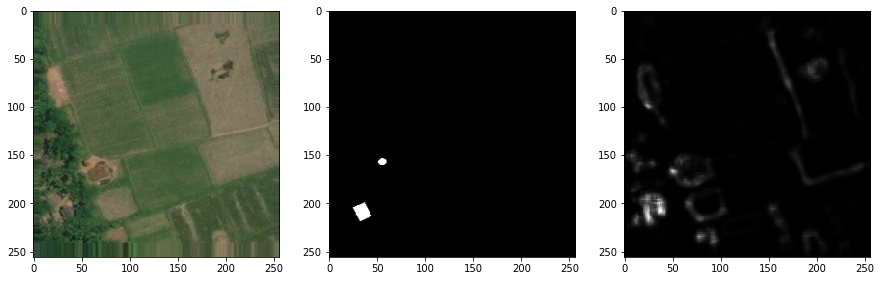

In [120]:
i = 12
plot_prediction_versus_truth(img[i], mask[i], preds[i])



In [130]:
jaccard_loss = jaccard_distance_loss(mask[i], preds[i])
crossentropy_loss = tf.keras.backend.binary_crossentropy(mask[i], preds[i], from_logits=True)

In [138]:
def plot_losses(cross, jaccard):
    plt.figure(figsize=(15, 50))
    
    plt.subplot(121).imshow(np.array(cross, dtype='float').reshape(256, 256), cmap='gray')
    plt.subplot(122).imshow(np.array(jaccard, dtype='float').reshape(256, 256), cmap='gray')

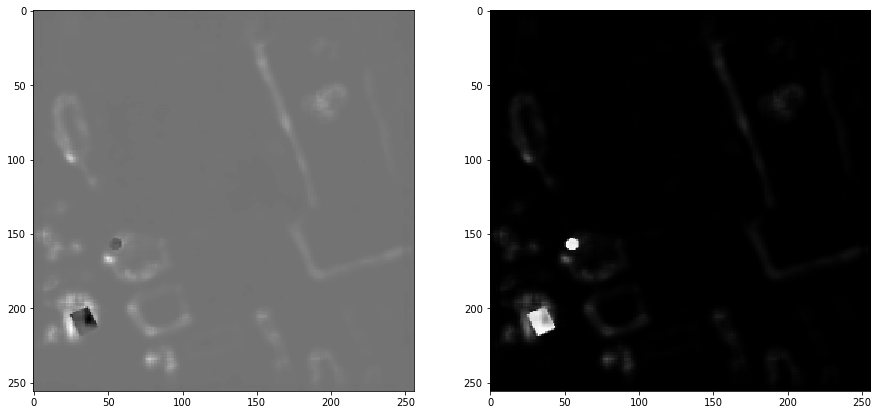

In [139]:
sess = tf.Session()

j_losses = sess.run(jaccard_loss)
c_losses = sess.run(crossentropy_loss)

plot_losses(c_losses, j_losses)